In [1]:
import os
import numpy as np
import mne
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
import pandas as pd
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
from copy import deepcopy
from mne.preprocessing import create_ecg_epochs, create_eog_epochs, read_ica
import sys

In [2]:
global ratio_TD_all
ratio_TD_all = []
global ratio_TU_all
ratio_TU_all = []
global ratio_DU_all
ratio_DU_all = []
dataDir = "./Light"
subject_name = 'S11'
file_path = os.path.join(dataDir,subject_name + " Data.cnt")
raw = mne.io.read_raw_cnt(file_path, preload=True)
# picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True, exclude='bads')
picks = mne.pick_channels(raw.info["ch_names"], ['O1', 'OZ', 'O2'])    

FileNotFoundError: [Errno 2] No such file or directory: '/data/home/viscent/Light/LangouEEG/Light/S11 Data.cnt'

1 duplicate electrode labels found:
M1/Trigger
Plotting 66 unique labels.
Creating RawArray with float64 data, n_channels=66, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


<ipython-input-3-08d21b5264f3>:10: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  mne.viz.plot_montage(layout)


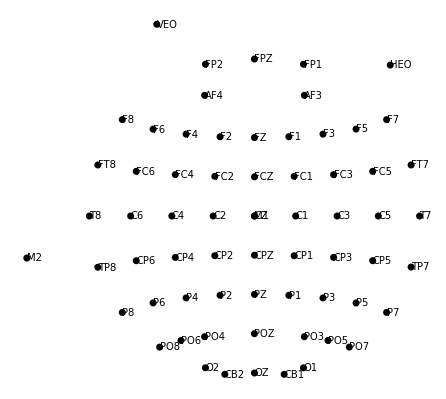

<RawCNT | S11 Data.cnt, 66 x 1562350 (3124.7 s), ~786.8 MB, data loaded>

In [3]:
layout = pd.read_csv(sys.path[0] + '\\channel_dict.txt', sep = '\t')
layout.columns = layout.columns.str.strip()
layout["labels"] = layout["labels"].str.strip()
layout = layout.set_index('labels')
layout = layout.to_dict(orient = "index")
for channel in layout.keys():
    yxz = np.array([layout[channel]["Y"], layout[channel]["X"], layout[channel]["Z"]])
    layout[channel] = yxz
layout = mne.channels.make_dig_montage(layout, coord_frame='head')
mne.viz.plot_montage(layout)

raw.set_montage(layout)

In [4]:
# cnt file describe
print("file info:")
print(raw.info)
print("channel names:")
print(raw.info["ch_names"])
print("time period:")
print(raw.n_times)
#print("time points:")
#print(raw.times)
print("events:")
events, event_dict = mne.events_from_annotations(raw)
event_dict = {'random_flicker-60s':1, 'random_rest-300s':2, '40Hz_rest-300s':3, '40Hz_flicker-60s':4}
print(event_dict)

file info:
<Info | 10 non-empty values
 bads: 1 items (Trigger)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 66 EEG
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>
channel names:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'Trigger']
time period:
1562350
events:
Used Annotations descriptions: ['11', '12', '8', '9']
{'random_flicker-60s': 1, 'random_rest-300s': 2, '40Hz_rest-300s': 3, '40Hz_flicker-60s': 4}


In [ ]:
raw.filter(0.1, None, fir_design='firwin')

# 可以考虑使用所有通道的平均值作为参考
# raw = raw.copy().set_eeg_reference(ref_channels='average')
# 使用特定的参考电极
raw = raw.copy().set_eeg_reference(ref_channels=['M1', 'M2'], projection=False)

raw = raw.copy().notch_filter(freqs=50,method='spectrum_fit')
raw.plot_psd(area_mode='range', tmax=10.0, picks=picks, average=False)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Filter length: 16501 samples (33.002 sec)

EEG channel type selected for re-referencing
Applying a custom EEG reference.


In [ ]:
# Plot raw data
img_raw_psd = raw.plot_psd()
# Print
scale = dict(mag=1e-12, grad=4e-11, eeg=128e-6, eog=150e-6, ecg=5e-4,
     emg=1e-3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1, chpi=1e-4, whitened=1e2)
# Set fig size
img_raw_plot = raw.plot(duration = 40, n_channels=65, scalings=scale,start=288)
img_raw_plot.set_size_inches([20,20])
img_raw_plot.savefig(sys.path[0] + '\\img_raw_plot3.png', dpi=300)

In [ ]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state=0)
ica.fit(raw)
# ica.plot_components()
bad_ica = ica.detect_artifacts(raw).exclude
raw = ica.apply(raw.copy(), exclude=bad_ica)

In [ ]:
# Get epoch for each event
tmin_rest = 60
tmax_rest = 120
tmin_flick = 3
tmax_flick = 60
## Epoch: Random flicker
event_id = 1
tmin = tmin_flick
tmax = tmax_flick
epoch_RF = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_flick, tmin_flick), preload=True,
                    reject=dict())
evoked_RF = epoch_RF.average()
#evoked_RF.plot(time_unit='s')
## Epoch: Random rest
event_id = 2
tmin = tmin_rest
tmax = tmax_rest
epoch_RR = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_rest, tmin_rest), preload=True,
                    reject=dict())
evoked_RR = epoch_RR.average()
#evoked_RR.plot(time_unit='s')
## Epoch: 40 Hz rest
event_id = 3
tmin = tmin_rest
tmax = tmax_rest
epoch_4R = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_rest, tmin_rest), preload=True,
                    reject=dict())
#epoch_4R.drop([0,1])
evoked_4R = epoch_4R.average()
#evoked_4R.plot(time_unit='s')
## Epoch: 40 Hz rest
event_id = 4
tmin = tmin_flick
tmax = tmax_flick
epoch_4F = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks,baseline=(tmin_flick, tmin_flick), preload=True, 
                    reject=dict())
epoch_4F_all = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    baseline=(tmin_flick, tmin_flick), preload=True, 
                    reject=dict())
# epoch_4F.drop([0,1])
#epoch_4F_all.drop([0,1])
evoked_4F = epoch_4F.average()
#evoked_4F.plot(time_unit='s')

In [ ]:
def add_arrows(axes):
    # add some arrows at 60 Hz and its harmonics
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        freq = 40
        idx = np.searchsorted(freqs, freq)
        # get ymax of a small region around the freq. of interest
        y = psds[(idx - 4):(idx + 5)].max()
        ax.arrow(x=freqs[idx], y=y + 18, dx=0, dy=-12, color='red',
                 width=0.1, head_width=3, length_includes_head=True)

In [ ]:
epoch_4R.plot_psd(fmin=0.1, fmax=100., average=True, spatial_colors=False)
epoch_4R.plot_psd_topomap(bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')],ch_type='eeg')
epoch_4F_all.plot_psd(fmin=0.1, fmax=100., average=True, spatial_colors=False)
epoch_4F.plot_psd_topomap(bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')],ch_type='eeg')
epoch_RR.plot_psd(fmin=0.1, fmax=100., average=True, spatial_colors=False)
epoch_RR.plot_psd_topomap(bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')],ch_type='eeg')
epoch_RF.plot_psd(fmin=0.1, fmax=100., average=True, spatial_colors=False)
epoch_RF.plot_psd_topomap(bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (30, 45, 'Gamma')],ch_type='eeg')

In [ ]:
fmin = 35
fmax = 45
alpha = .2
def plot_psd_sub(epoch, fmin=.1, fmax=100, n_jobs=1, color='k', alpha=.5, label='Default'):
    psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=n_jobs)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    ax.plot(freqs, psds_mean, color=color, label = label)
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color=color, alpha=alpha)
    ax.legend()

f, ax = plt.subplots(figsize=(15,7))
plot_psd_sub(epoch = epoch_4R, color='y', fmin=fmin, fmax=fmax, alpha=alpha, label='Rest State')
plot_psd_sub(epoch = epoch_4F, color='k', fmin=fmin, fmax=fmax, alpha=alpha, label='40 Hz Light Stimulation')
plot_psd_sub(epoch = epoch_RF, color='r', fmin=fmin, fmax=fmax, alpha=alpha, label='Random Hz Light Stimulation')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density (PSD) in log")
plt.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_35_45.png')

In [ ]:
psds, freqs = psd_multitaper(epoch_4F,fmin=fmin, fmax=fmax, n_jobs=8,picks=['O1', 'OZ', 'O2']) 
# psd.shape: (number of epoch, number of channel, frequency)
f_down = 35.0
f_low = 39.0
f_high = 41.0
f_upstream = 45.0
print(psds.shape)
num_of_epoch = psds.shape[0]
num_of_channel = psds[0].shape[0]
print("{0} epochs in total".format(num_of_epoch))
print("{0} channels in total".format(num_of_channel))
print(psds.shape)
# average all channels
psds = np.mean(psds, axis=1)
# extract power in selected frequency bands
downstream_mean_power, target_mean_power, upstream_mean_power = [],[],[]
for i in range(0, num_of_epoch):
    a,b,c = [],[],[]
    for j in range(0, len(freqs)):
        freq = freqs[j]
        power = psds[i][j]
        if freq < f_low and freq > f_down:
            a.append(power)
        if freq < f_high and freq > f_low:
            b.append(power)
        if freq < f_upstream and freq > f_high:
            c.append(power)
    downstream_mean_power.append(np.max(a))
    target_mean_power.append(np.max(b))
    upstream_mean_power.append(np.max(c))
print(r'The downstream mean power is:')
print(downstream_mean_power)
print(r'The taget band mean power is:')
print(target_mean_power)
print(r'The upstream mean power is:')
print(upstream_mean_power)
ratio_TD = []
ratio_TU = []
ratio_DU = []
for i in range(0, len(target_mean_power)):
    TD = target_mean_power[i]/downstream_mean_power[i]
    TU = target_mean_power[i]/upstream_mean_power[i]
    DU = downstream_mean_power[i]/upstream_mean_power[i]
    ratio_TD.append(TD)
    global ratio_TD_all
    ratio_TD_all.append(TD)
    ratio_TU.append(TU)
    global ratio_TU_all
    ratio_TU_all.append(TU)
    ratio_DU.append(DU)
    global ratio_DU_all
    ratio_DU_all.append(DU)
print(r'The target/downstream is:')
print(ratio_TD)
print(r'The target/upstream is:')
print(ratio_TU)
print(r'The downstream/upstream is:')
print(ratio_DU)

In [ ]:
df = pd.DataFrame()
df['ratio_TD'] = ratio_TD_all
df['ratio_TU'] = ratio_TU_all
df['ratio_DU'] = ratio_DU_all
df.to_csv(sys.path[0] + '\\Light\\ratios.csv')

In [ ]:
fmin = 0
fmax = 120
alpha = .2
def plot_psd_sub(epoch, fmin=.1, fmax=100, n_jobs=1, color='k', alpha=.5, label='Default'):
    psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=n_jobs)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    ax.plot(freqs, psds_mean, color=color, label = label)
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color=color, alpha=alpha)
    ax.legend()
f, ax = plt.subplots(figsize=(25,10))
plot_psd_sub(epoch = epoch_4R, color='y', fmin=fmin, fmax=fmax, alpha=alpha, label='Rest State')
plot_psd_sub(epoch = epoch_4F, color='k', fmin=fmin, fmax=fmax, alpha=alpha, label='40 Hz Light Stimulation')
plot_psd_sub(epoch = epoch_RF, color='r', fmin=fmin, fmax=fmax, alpha=alpha, label='Random Hz Light Stimulation')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density (PSD) in log")
plt.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_0_120.png')

In [ ]:
fmin = 40
fmax = 85
alpha = .2
def plot_psd_sub(epoch, fmin=.1, fmax=100, n_jobs=1, color='k', alpha=.5, label='Default'):
    psds, freqs = psd_multitaper(epoch, fmin=fmin, fmax=fmax, n_jobs=n_jobs)
    psds = 10. * np.log10(psds)
    psds_mean = psds.mean(0).mean(0)
    psds_std = psds.mean(0).std(0)
    ax.plot(freqs, psds_mean, color=color, label = label)
    ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color=color, alpha=alpha)
    ax.legend()
f, ax = plt.subplots(figsize=(15,7))
plot_psd_sub(epoch = epoch_4R, color='y', fmin=fmin, fmax=fmax, alpha=alpha, label='Rest State')
plot_psd_sub(epoch = epoch_4F, color='k', fmin=fmin, fmax=fmax, alpha=alpha, label='40 Hz Light Stimulation')
plot_psd_sub(epoch = epoch_RF, color='r', fmin=fmin, fmax=fmax, alpha=alpha, label='Random Hz Light Stimulation')
plt.xlabel("Frequency")
plt.ylabel("Power spectral density (PSD) in log")
plt.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_40_85.png')

In [ ]:
picks = mne.pick_channels(raw.info['ch_names'],include=[])
# Get epoch for each event
tmin_rest = 3
tmax_rest = 300
tmin_flick = 3
tmax_flick = 60
## Epoch: Random flicker
event_id = 1
tmin = tmin_flick
tmax = tmax_flick
epoch_RF = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_flick, tmin_flick), preload=True,
                    reject=dict())
evoked_RF = epoch_RF.average()
#evoked_RF.plot(time_unit='s')
## Epoch: Random rest
event_id = 2
tmin = tmin_rest
tmax = tmax_rest
epoch_RR = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_rest, tmin_rest), preload=True,
                    reject=dict())
evoked_RR = epoch_RR.average()
#evoked_RR.plot(time_unit='s')
## Epoch: 40 Hz rest
event_id = 3
tmin = tmin_rest
tmax = tmax_rest
epoch_4R = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=(tmin_rest, tmin_rest), preload=True,
                    reject=dict())
#epoch_4R.drop([0,1])
evoked_4R = epoch_4R.average()
#evoked_4R.plot(time_unit='s')
## Epoch: 40 Hz rest
event_id = 4
tmin = tmin_flick
tmax = tmax_flick
epoch_4F = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks,baseline=(tmin_flick, tmin_flick), preload=True, 
                    reject=dict())
epoch_4F_all = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    baseline=(tmin_flick, tmin_flick), preload=True, 
                    reject=dict())
epoch_4F.drop([0])
#epoch_4F_all.drop([0,1])
evoked_4F = epoch_4F.average()
bands = [(0, 4, 'Delta'), (4, 8, 'Theta'), (8, 12, 'Alpha'),
         (12, 30, 'Beta'), (39, 41, 'Gamma (39-41 Hz)')]
fig = epoch_4R.plot_psd_topomap(bands = bands,ch_type='eeg')
fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_topo_4R.png')
fig = epoch_4F.plot_psd_topomap(bands = bands,ch_type='eeg')
fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_topo_4F.png')
fig = epoch_RR.plot_psd_topomap(bands = bands,ch_type='eeg')
fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_topo_RR.png')
fig = epoch_RF.plot_psd_topomap(bands = bands,ch_type='eeg')
fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_topo_RF.png')

In [ ]:
freqs = np.logspace(*np.log10([35, 45]), num=8)
n_cycles = freqs / 2.0
power_4F = tfr_morlet(epoch_4F, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1)
type(power_4F)
power_4R = tfr_morlet(epoch_4R, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1)
type(power_4F)
power_RF = tfr_morlet(epoch_RF, freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=1)
type(power_4F)

In [ ]:
fig, axis = plt.subplots(1, 3, figsize=(20, 7))
fig = power_4F.plot_topomap(ch_type="eeg", tmin=tmin_flick, tmax=tmax_flick, 
                      fmin=35, fmax=45, baseline=(tmin_flick, tmin_flick), mode="logratio", title="40 Hz flicker", axes=axis[0],show=False)
# fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_powertopo_4F.png')
fig = power_4R.plot_topomap(ch_type="eeg", tmin=tmin_rest, tmax=tmax_rest, 
                      fmin=35, fmax=45, baseline=(tmin_rest, tmin_rest), mode="logratio", title="Rest state", axes=axis[1],show=False)
# fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_powertopo_4R.png')
fig = power_RF.plot_topomap(ch_type="eeg", tmin=tmin_flick, tmax=tmax_flick, 
                      fmin=35, fmax=45, baseline=(tmin_flick, tmin_flick), mode="logratio", title="Random Hz flicker", axes=axis[2],show=False)
fig.savefig(sys.path[0] + '\\Light\\Light_figures\\' + subject_name + '_powertopo.png')